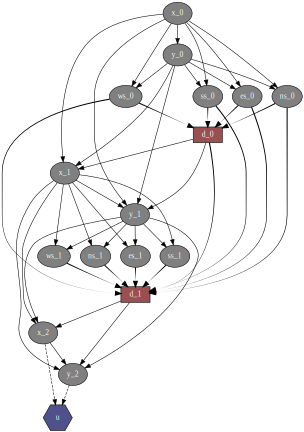

SIS de : d_1  |  ['x_2']


InvalidDirectedCycle: [pyAgrum] Directed cycle detected: Add a directed cycle in a dag !

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from bandbLIMID import BranchAndBoundLIMIDInference
from exemple_robot import createIDRobot


maze=["---------",
      "--     --",
      "-  - -  -",
      "-- - - --",
      "-  - - $-",
      "--     --",
      "---------"]
nbStage=2
xInitial=3
yInitial=2
ID=createIDRobot(nbStage,xInitial,yInitial,maze)
gnb.showInfluenceDiagram(ID)
ordre=[]
for i in range(nbStage):
    ordre.append(ID.idFromName("d_"+str(i)))
bnb=BranchAndBoundLIMIDInference(ID,ordre)
gnb.showInfluenceDiagram(bnb.IDRelaxe)


In [8]:
ID=gum.fastID('D->A->*B->F->$C')
bnb=BranchAndBoundLIMIDInference(ID,[ID.idFromName("B")])
graph,x,y=bnb.fromIDToMoralizedAncestral(ID.idFromName("B"),ID)
graph

SIS de : B  |  ['D']


AttributeError: 'UndiGraph' object has no attribute 'set_size'